## **Satellite Image Classification Using VGG-16**

<img src="https://i.ibb.co/8bzFfr5/Course-Project-Cover-Image.png" alt="Course Project Cover Image" width="200%">

<h2><b>Introduction</b></h2>

<h4>Basic Idea for the Project</h4>

<p>Satellite image classification can be used for environmental monitoring and assessment, allowing businesses to analyze the state of different areas of land from a remote location.</p>
<p>The classification model can support land management and urban planning by identifying regions suitable for development, preservation, or conservation.</p>
<p>It enables monitoring of natural resources such as water bodies, forests, and agricultural land, aiding in the identification of potential issues or changes over time.</p>
<p>The model can assist in disaster management by quickly assessing the impact of natural disasters like wildfires, floods, or storms on different land areas.</p>
<p>Industries like agriculture, forestry, and renewable energy can benefit from satellite image classification by optimizing resource allocation and decision-making processes based on the classification results.</p>


<h2>Dataset Information</h2>

<p>The dataset is a compressed RAR file created by subsetting the Satellite Dataset from Kaggle.</p>
<p>You can access the dataset from this Kaggle link: <a href="https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification">Satellite Image Classification Dataset</a>.</p>
<p>The dataset consists of images categorized into four classes: desert, green area, cloudy, and water.</p>
<p>It includes a total of 500 training images, 150 testing images, and 50 validation images.</p>

### **Mounting the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing the necessary libraries**

In [2]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install gradio

In [4]:
import os
import numpy as np
import patoolib
import torch
import torchvision
import random

# For converting the images to tensors
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt

# For visualizing the images
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Setting the background of the plots as white
matplotlib.rcParams["figure.facecolor"] = "#ffffff"

# For plotting a grid of images
from torchvision.utils import make_grid

# For Creating DataLaoders
from torch.utils.data.dataloader import DataLoader

# For Creating the neural networks
import torch.nn as nn
import torch.nn.functional as F

# For using Pre-trained models
from torchvision import models

# For the traninig progress bar
from tqdm.notebook import tqdm

# For the textual warinings
import warnings
warnings.filterwarnings("ignore")

# For Deploying the model on Gradio
import gradio as gr
from PIL import Image

**Extracting the files**

In [11]:
patoolib.extract_archive("/content/drive/MyDrive/Satellite DatasetV2.rar")

patool: Extracting /content/drive/MyDrive/Satellite DatasetV2.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Satellite DatasetV2.rar"
patool:     with cwd='./Unpack_wkigoe2z'
patool: ... /content/drive/MyDrive/Satellite DatasetV2.rar extracted to `Satellite Dataset'.


'Satellite Dataset'

**Checking the number of classes in the training Dataset**

In [ ]:
data_dir = "./Satellite Dataset"
print(os.listdir(data_dir))

# Checking the clases in the train data
classes = os.listdir(data_dir +"/Train")
print(classes)

['Test', 'Train', 'Validation']
['cloudy', 'desert', 'green_area', 'water']


**Going hrough the directories and their folders to check the number of images for each classes.**

In [ ]:
train_directory = "./Satellite Dataset/Train"
num_images = []
for root, dirs, files in os.walk(train_directory):
  if files == []:
    continue
  else:
    num_images.append(len(files))
print(num_images)

[500, 500, 500, 500]


In [ ]:
val_directory = './Satellite Dataset/Validation'

num_images = []
for root, dirs, files in os.walk(val_directory):
  if files == []:
    continue
  else:
    num_images.append(len(files))
print(num_images)

[50, 50, 50, 50]


In [ ]:
test_directory = './Satellite Dataset/Test'

num_images = []
for root, dirs, files in os.walk(test_directory):
  if files == []:
    continue
  else:
    num_images.append(len(files))
print(num_images)

[150, 150, 150, 150]


**Checking the size of the images to make sure everything is in order before we feed the image tensors to the model to train on.**

In [ ]:
# to test the size of the images
image_size_test = ImageFolder(train_directory, tt.ToTensor())
len(image_size_test)

2000

In [ ]:
#checking the size of the first 10 images in the dataset

im_count = 0
for image,_ in image_size_test:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [ ]:
#checking the maximum and minimum size of the images of the whole dataset
height = []
width = []
for image,_ in image_size_test:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))

minimum height: 64, maximum height: 256, minimum width: 64, maximum width: 256


**Taking a look at some of the examples from the train and test folders**

In [ ]:
green_area_images = os.listdir(data_dir + "/Train/green_area")
print("Number of training examples for green_area_images : ", len(green_area_images))
print(green_area_images[:5])

Number of training examples for green_area_images :  500
['Forest_2245.jpg', 'Forest_2067.jpg', 'Forest_2053.jpg', 'Forest_2246.jpg', 'Forest_949.jpg']


In [ ]:
len(classes)

4

**Converting the training and validation images to PyTorch tensors and applying the necessary transformations to the Data**

In [ ]:
fixed_size = 244
# Data transforms (normalization & data augmentation)
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = tt.Compose([tt.Resize(fixed_size),
                         tt.RandomCrop(fixed_size, padding=8, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])


test_tfms = tt.Compose([tt.Resize(fixed_size),tt.ToTensor(), tt.Normalize(*stats)])
val_tfms = tt.Compose([tt.Resize(fixed_size), tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_data = ImageFolder(data_dir + "/Train", transform = train_tfms, )
test_data = ImageFolder(data_dir + "/Test", transform = test_tfms)

In [ ]:
#checking the size of the first 10 images in the train dataset after transformation

im_count = 0
for image,_ in train_data:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break

torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])


In [ ]:
#checking the size of the first 10 images in the val dataset after transformation

im_count = 0
for image,_ in test_data:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break

torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])
torch.Size([3, 244, 244])


In [ ]:
len(train_data), len(test_data)

(2000, 600)

### **Creating the Training and Validation Data Loaders**

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size, num_workers = 4, pin_memory = True)

**Denormalizing the images and plotting a Batch of them**

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

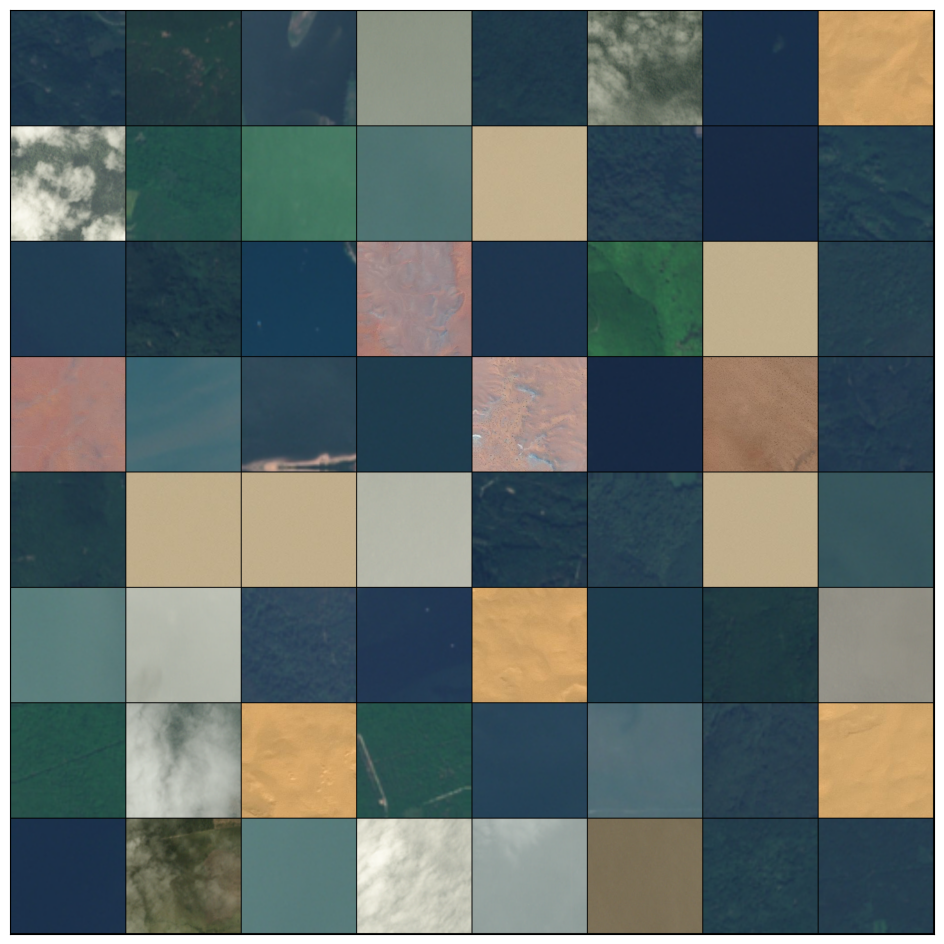

In [ ]:
show_batch(train_dl)

###**Utility functions to run the code seamlessly on a GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

**Getting the Default device**

In [ ]:
device = get_default_device()
device

device(type='cuda')

**Tansferring the DataLoaders to the GPU**

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

**Defining the accuracy function**

In [ ]:
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

**Defining the ImageClassificationBase by extending the nn.Module class**

In [5]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate Predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)         # Calculate the loss and accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predicitons
        loss = F.cross_entropy(out, labels) # Calculate the loss
        acc = accuracy(out, labels)         # Clacultate the accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_acc'], result['val_loss']))

### **Defining the VGG-16 model**

In [6]:
class SeaModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained VGG16 model
        self.network = models.vgg16(pretrained=pretrained)

        # Freeze all parameters by default
        for param in self.network.parameters():
            param.requires_grad = False

        # Fine-tune the last 3 layers
        self.network.classifier[1].requires_grad = True
        self.network.classifier[3].requires_grad = True
        self.network.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, xb):
        return self.network(xb)

### **Traning the model**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### **Fine-Tuning the Pretrainied Model**

In [ ]:
model = SeaModel(len(classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 246MB/s]


In [ ]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 1.3893293142318726, 'val_acc': 0.2718749940395355}]

**Defining the base parameters for training the model**

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00271, train_loss: 0.6527, val_acc: 0.9651, val_loss: 0.2368
Epoch [1], last_lr: 0.00755, train_loss: 0.1025, val_acc: 0.9828, val_loss: 0.0812
Epoch [2], last_lr: 0.01000, train_loss: 0.0497, val_acc: 0.9891, val_loss: 0.0537
Epoch [3], last_lr: 0.00950, train_loss: 0.0443, val_acc: 0.9953, val_loss: 0.0341
Epoch [4], last_lr: 0.00812, train_loss: 0.0276, val_acc: 0.9922, val_loss: 0.0356
Epoch [5], last_lr: 0.00611, train_loss: 0.0366, val_acc: 0.9922, val_loss: 0.0308
Epoch [6], last_lr: 0.00389, train_loss: 0.0274, val_acc: 0.9937, val_loss: 0.0325
Epoch [7], last_lr: 0.00188, train_loss: 0.0290, val_acc: 0.9922, val_loss: 0.0297
Epoch [8], last_lr: 0.00050, train_loss: 0.0298, val_acc: 0.9937, val_loss: 0.0276
Epoch [9], last_lr: 0.00000, train_loss: 0.0200, val_acc: 0.9937, val_loss: 0.0273
CPU times: user 1min 46s, sys: 8.4 s, total: 1min 54s
Wall time: 3min


### **Plotting the Accuracies and the Losses**

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

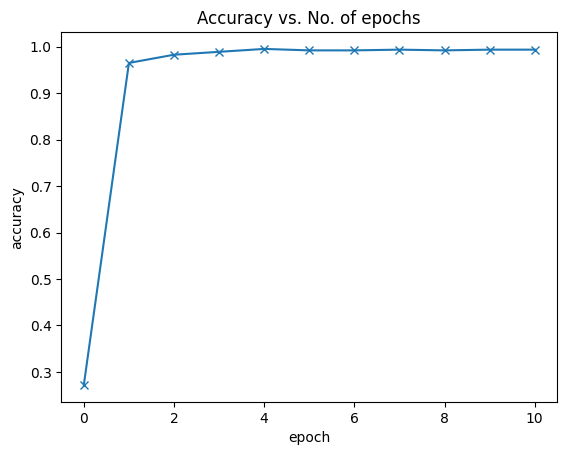

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

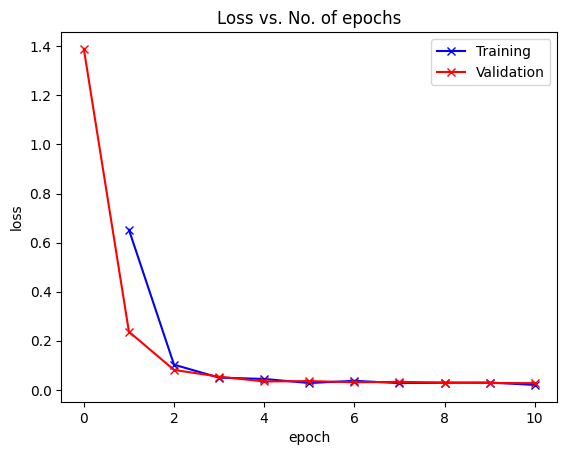

In [ ]:
plot_losses(history)

**Plotting the Learning Rate**

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

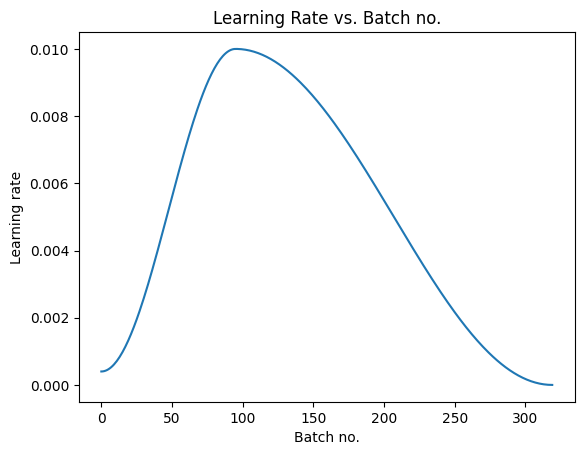

In [ ]:
plot_lrs(history)

### **Testing the mode on unseen Data**

**Performing the necessary transformations on the validation data**

In [ ]:
val_data = ImageFolder(data_dir + "/Validation", transform = val_tfms)
val_dl = DataLoader(test_data, batch_size, num_workers = 4, pin_memory = True)
val_dl = DeviceDataLoader(val_dl, device)

**Declaring the necessary functions**

In [ ]:
def denormalize(images, means, stds):
    device = images.device
    means = torch.tensor(means, device=device).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds, device=device).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image_predictions(model, val_dl, stats, val_data):
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_dl):
            if i >= 10:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Denormalize images
            denorm_images = denormalize(images, *stats)

            # Convert tensors to numpy arrays
            images_np = denorm_images.permute(0, 2, 3, 1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            predicted_np = predicted.cpu().numpy()

            # Reverse transformations and plot the image
            image = val_data.imgs[i][0]
            actual_class = val_data.classes[labels_np[i]]
            predicted_class = val_data.classes[predicted_np[i]]

            # Display the actual and predicted values
            print(f"Image: {image}")
            print(f"Actual: {actual_class}")
            print(f"Predicted: {predicted_class}\n")

            # Plot the image
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(images_np[i].clip(0, 1))
            ax.axis('off')
            plt.show()

**Seeing the predicitons made by our model**

Image: ./Satellite Dataset/Validation/cloudy/train_32431.jpg
Actual: cloudy
Predicted: cloudy



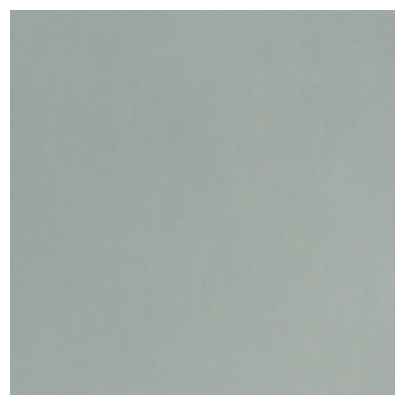

Image: ./Satellite Dataset/Validation/cloudy/train_32433.jpg
Actual: cloudy
Predicted: cloudy



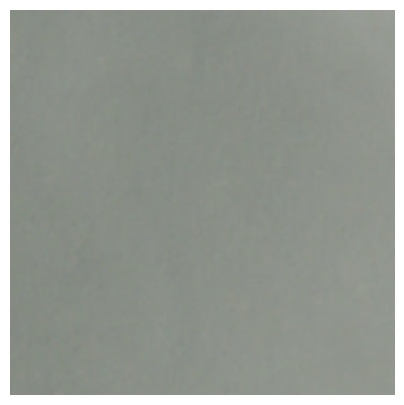

Image: ./Satellite Dataset/Validation/cloudy/train_32513.jpg
Actual: cloudy
Predicted: cloudy



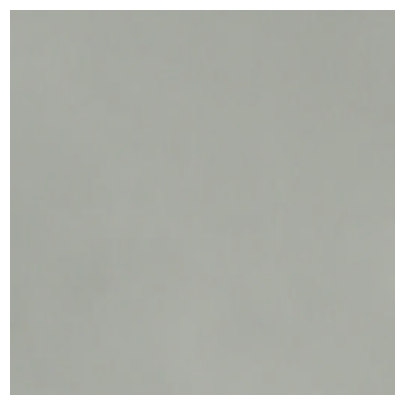

Image: ./Satellite Dataset/Validation/cloudy/train_32526.jpg
Actual: desert
Predicted: desert



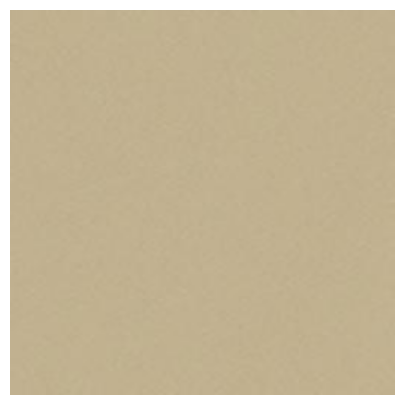

Image: ./Satellite Dataset/Validation/cloudy/train_32613.jpg
Actual: desert
Predicted: desert



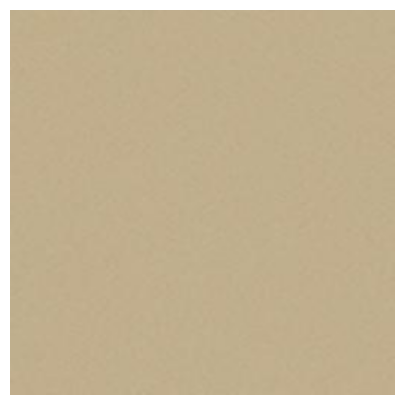

Image: ./Satellite Dataset/Validation/cloudy/train_32617.jpg
Actual: green_area
Predicted: green_area



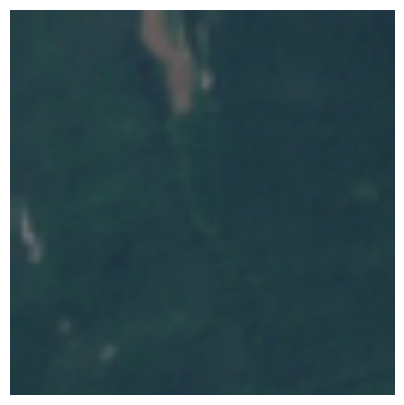

Image: ./Satellite Dataset/Validation/cloudy/train_32670.jpg
Actual: green_area
Predicted: green_area



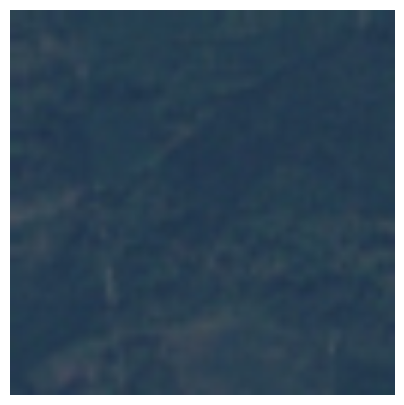

Image: ./Satellite Dataset/Validation/cloudy/train_32698.jpg
Actual: water
Predicted: water



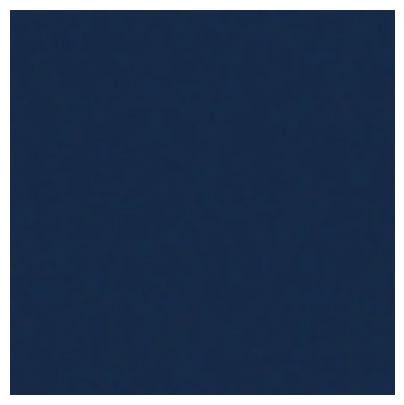

Image: ./Satellite Dataset/Validation/cloudy/train_32704.jpg
Actual: water
Predicted: water



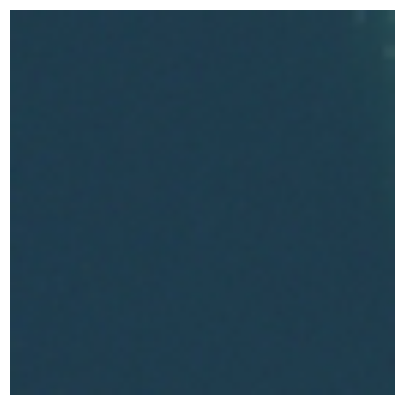

Image: ./Satellite Dataset/Validation/cloudy/train_32717.jpg
Actual: water
Predicted: water



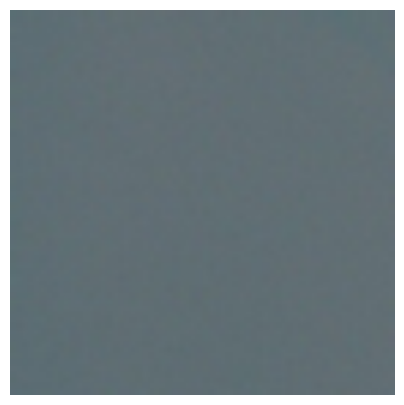

In [ ]:
show_image_predictions(model, val_dl, stats, val_data)

### **Saving the model**

In [ ]:
folder_path = "/content/drive/MyDrive/"
torch.save(model.state_dict(), folder_path + 'Satellite_model_vgg16.pth')

### **Deployment in a Gradio Interface**

**Loading in the Saved Model**

In [7]:
# Create an instance of the modified VGG16 model
model = SeaModel(num_classes=4, pretrained=False)

# Define the path to your pre-trained model
model_path = '/content/drive/MyDrive/Satellite_model_vgg16.pth'

# Load the pre-trained weights into the model
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Adjust the keys in the state dictionary to match the modified model
adjusted_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('network.features'):
        adjusted_state_dict['network.' + k[8:]] = v
    elif k.startswith('network.classifier'):
        adjusted_state_dict['network.' + k[8:]] = v

# Load the adjusted state dictionary into the model
model.load_state_dict(adjusted_state_dict)

# Set the model to evaluation mode
model.eval()

SeaModel(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [8]:
# Define the image preprocessing transformation
preprocess = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Define the prediction function
def predict_image(image):
    # Preprocess the image
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    image = preprocess(image)

    # Add a batch dimension and convert to a tensor
    image = image.unsqueeze(0)

    # Perform the forward pass
    with torch.no_grad():
        output = model(image)

    # Get the predicted class label
    _, predicted_idx = torch.max(output, 1)
    predicted_label = class_labels[predicted_idx.item()]

    return predicted_label

# Define the class labels
class_labels = ['Cloudy', 'Desert', 'Forest / Green Area', 'Ocean / Water Body']

In [10]:
# Create the Gradio interface
im = gr.inputs.Image(shape=(224, 224))
label = gr.outputs.Label(num_top_classes=1)
interface = gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="VGG DEMO")

# Launch the interface
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6c28a1a2095e41c4cd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<h2>Conclusion</h2>

<p>The VGG16 model trained on the satellite image dataset achieved impressive results in the final epoch:</p>
<ul>
  <li>Validation Accuracy (val_acc): 0.9937</li>
  <li>Validation Loss (val_loss): 0.0273</li>
</ul>

<h2>Summary</h2>

<ul>
  <li>Satellite image classification using the trained VGG16 model enables businesses to remotely monitor and assess the environmental conditions of different land areas.</li>
  <li>The classification model supports land management and urban planning by identifying suitable regions for development, preservation, or conservation.</li>
  <li>It aids in the monitoring of natural resources like water bodies, forests, and agricultural land, allowing for the identification of potential issues or changes over time.</li>
  <li>The model also assists in disaster management by quickly assessing the impact of natural disasters on various land areas.</li>
  <li>Industries such as agriculture, forestry, and renewable energy can benefit from satellite image classification, optimizing resource allocation and decision-making based on the classification results.</li>
  <li> The model was deployed locally with the help of Gradio for inference and testing using a bunch of images from the Internet
</ul>


<h2>References</h2>

<p>1. Mahmoud Reda. (n.d.). Satellite Image Classification Dataset. Retrieved from <a href="https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification">https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification</a>.</p>

<h2>Future Work</h2>

<ul>
  <li>Explore advanced deep learning models such as Inception, or EfficientNet to further improve classification accuracy and performance.</li>
  <li>Expanding the dataset by collecting more satellite images from diverse geographic regions to enhance the model's generalization capabilities.</li>
  <li>Extend the classification task to include additional classes or subcategories relevant to specific applications, such as urban areas, agricultural crops, or industrial zones.</li>
</ul>
